In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers
import cv2
import csv

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [11]:
#Mount google drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
model_path = "./gdrive/MyDrive/models/region_guessr_reg_eff_net_mdl_wts.hdf5" 
images_path = "./gdrive/MyDrive/lumen/data/"
train_annotations_path = "./gdrive/MyDrive/lumen/train_annotations.csv"
#model_path = "./gdrive/MyDrive/models/effnetB2_mdl_wts_mark2.hdf5"
IMAGE_SIZE = 128

In [13]:
def build_model():
  inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  # model = EfficientNetB4(include_top=False, input_tensor=inputs, weights="imagenet")
  # model.trainable = False
  model = EfficientNetB4(include_top=False, input_tensor=inputs, weights="imagenet")
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)
  top_dropout_rate = 0.1
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mean_squared_error"])
  return model

In [29]:
def visualize_one_sample(image):
    plt.figure(figsize=(6, 4))
    image = np.array(image)
    plt.imshow(image[::, ::, ::-1], aspect='equal')
    current_axis = plt.gca()
    plt.show()

In [35]:
def get_data(file_name):
  annotations = open(file_name)
  images = []
  labels = []

  brojac = 0 ##Maknuti kada treba ucitati sve podatke
  for row in csv.reader(annotations):
    if brojac % 4 == 0:
      if brojac == 100: ##Maknuti kada treba ucitati sve podatke
        break          ##Maknuti kada treba ucitati sve podatke
      try:
        image = cv2.imread(images_path + row[0]) 
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        images.append(image)
      except:
        print(images_path + row[0])
    brojac += 1
    annotations.close()

  # print(labels[0][2:])
  # for i in range(len(images)):
  #   visualize_one_sample(images[i], [labels[i][2:]])
  # print(labels[:10])
  return np.array(images)

In [16]:
def create_heatmap(image, model, last_layer_name, pred_index=None):
  img_array = keras.preprocessing.image.img_to_array(image)
  img_array = np.expand_dims(img_array, axis=0)
  grad_model = tf.keras.models.Model([model.inputs], 
                                     [model.get_layer(last_layer_name).output, model.output])
  with tf.GradientTape() as tape:
        last_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
  grads = tape.gradient(class_channel, last_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
  last_layer_output = last_layer_output[0]
  heatmap = tf.matmul(last_layer_output, pooled_grads[..., tf.newaxis])
  heatmap = tf.squeeze(heatmap)
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

In [20]:
images = get_data(train_annotations_path)

./gdrive/MyDrive/lumen/data/uuid


In [31]:
model = build_model()
model.load_weights(model_path)
##model.summary()


last_layer_name = "block6e_project_conv" ##top_conv   block7a_expand_conv    block6e_project_conv
model.layers[-1].activation = None
##preds = model.predict(img_array)
##print(preds)

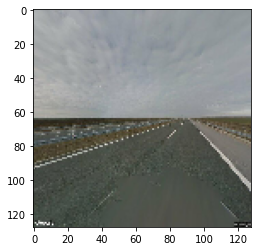

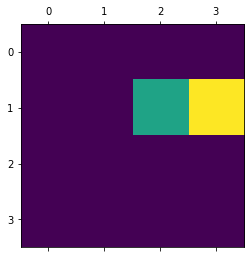

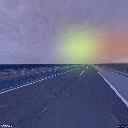

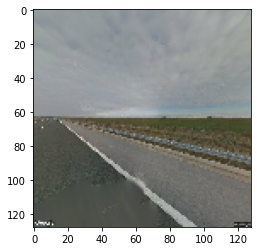

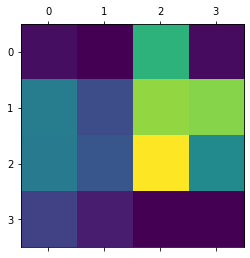

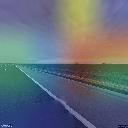

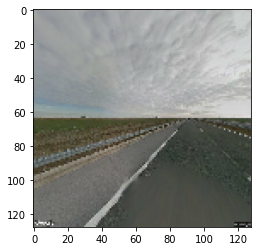

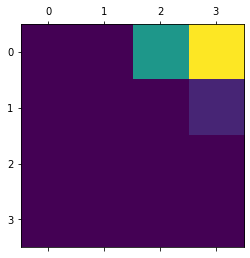

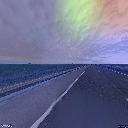

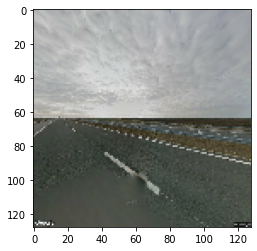

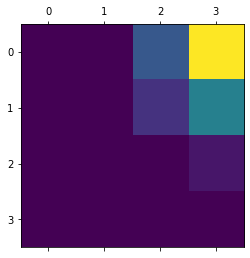

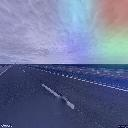

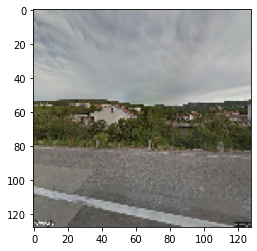

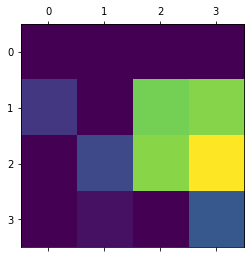

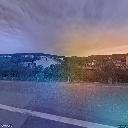

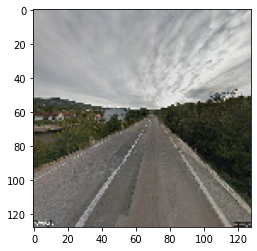

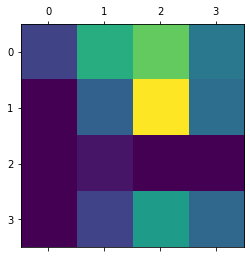

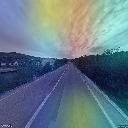

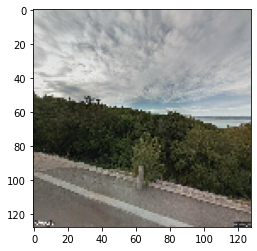

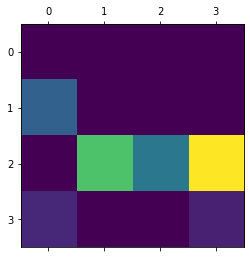

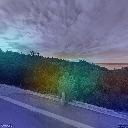

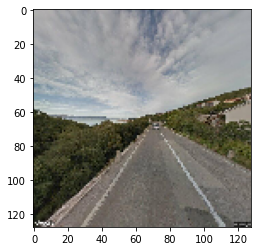

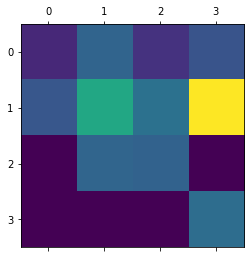

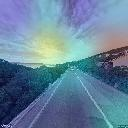

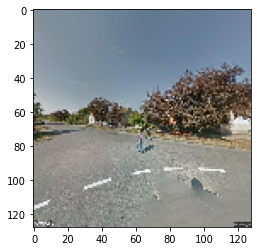

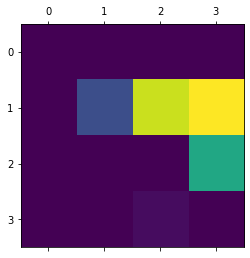

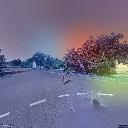

In [36]:
img_index = 0
for img_array in images:
  heatmap = create_heatmap(img_array, model, last_layer_name)
  visualize_one_sample(images[img_index])
  plt.matshow(heatmap)
  plt.show()
  cam_path = "cam.jpg"
  alpha = 0.4
  heatmap = np.uint8(255 * heatmap)

  jet = cm.get_cmap("jet")

  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * alpha + img_array
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


  superimposed_img.save(cam_path)
  display(Image(cam_path))
  img_index += 1